# Project 3 – Part A: Speech Act Classification

This notebook implements Part A of the Pragmatic Analysis Pipeline: a speech act classifier
that predicts whether an utterance is a **statement**, **question**, or **directive** using a
fine-tuned DistilBERT model on a 500-utterance subset of the Switchboard Dialogue Act Corpus.


In [1]:
!pip install -q transformers datasets scikit-learn nltk

import sys
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

from collections import Counter
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [2]:
!rm -rf swda swda_unzipped

!git clone -q https://github.com/cgpotts/swda.git
!unzip -q /content/swda/swda.zip -d swda_unzipped


In [3]:
# Make sure Python sees the cloned repo
sys.path.append("/content/swda")

# IMPORTANT: import CorpusReader from swda.swda, not from swda
from swda.swda import CorpusReader

corpus_root = "/content/swda_unzipped/swda"
corpus = CorpusReader(corpus_root)

utterances = []
for trans in corpus.iter_transcripts():
    for utt in trans.utterances:
        utterances.append({
            "text": utt.text,
            "damsl_act_tag": utt.damsl_act_tag
        })

df_all = pd.DataFrame(utterances)
df_all = df_all[df_all["text"].str.strip().astype(bool)]

def map_tag_to_label(tag: str) -> str:
    if tag is None:
        return "statement"
    tag = str(tag)

    # Questions
    if tag.startswith(("qy", "qw", "qwh", "qh", "qo")):
        return "question"

    # Directives
    if tag.startswith(("ad", "aa", "ar", "sv")):
        return "directive"

    # Default
    return "statement"

df_all["label"] = df_all["damsl_act_tag"].apply(map_tag_to_label)
print("Label distribution in full corpus:", Counter(df_all["label"]))

df = df_all.sample(n=500, random_state=42)[["text", "label"]].reset_index(drop=True)
df.head(), df["label"].value_counts()


transcript 1155


Label distribution in full corpus: Counter({'statement': 221616})


(                                                text      label
 0                                 {F Oh, } really. /  statement
 1  {C And } {D see } now we're dealing with havin...  statement
 2                                            Yeah. /  statement
 3                  there's a lot that can be done. /  statement
 4                                            Yeah, /  statement,
 label
 statement    500
 Name: count, dtype: int64)

In [4]:
# Label ids and splits
label2id = {"statement": 0, "question": 1, "directive": 2}
id2label = {v: k for k, v in label2id.items()}
df["label_id"] = df["label"].map(label2id)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

n = len(df)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

df_train = df.iloc[:train_end]
df_val = df.iloc[train_end:val_end]
df_test = df.iloc[val_end:]

dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(df_train[["text", "label_id"]]),
    "validation": Dataset.from_pandas(df_val[["text", "label_id"]]),
    "test": Dataset.from_pandas(df_test[["text", "label_id"]]),
})

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 64

def tokenize_fn(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=max_length
    )

tokenized_datasets = dataset_dict.map(tokenize_fn, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label_id", "labels")
tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

tokenized_datasets


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 350
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 75
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 75
    })
})

In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average=None, labels=[0, 1, 2]
    )

    return {
        "accuracy": acc,
        "precision_statement": precision[0],
        "recall_statement": recall[0],
        "f1_statement": f1[0],
        "precision_question": precision[1],
        "recall_question": recall[1],
        "f1_question": f1[1],
        "precision_directive": precision[2],
        "recall_directive": recall[2],
        "f1_directive": f1[2],
    }


num_labels = 3
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="./speech_act_distilbert",
    eval_strategy="epoch",          # <-- CHANGED: eval_strategy, not evaluation_strategy
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=20,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# Test evaluation
test_results = trainer.evaluate(tokenized_datasets["test"])
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")

# Speech-act predictor (for later Part B)
def predict_speech_act(utterance: str):
    model.eval()
    inputs = tokenizer(
        utterance,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_length
    )
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1).cpu().numpy()[0]

    pred_id = int(np.argmax(probs))
    pred_label = id2label[pred_id]
    confidence = float(probs[pred_id])

    return {
        "utterance": utterance,
        "speech_act": pred_label,
        "confidence": confidence,
        "all_probs": {id2label[i]: float(p) for i, p in enumerate(probs)}
    }

for ex in [
    "Can you open the window?",
    "Dolphins are marine mammals.",
    "Please close the door."
]:
    print(predict_speech_act(ex))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3608721486.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Statement,Recall Statement,F1 Statement,Precision Question,Recall Question,F1 Question,Precision Directive,Recall Directive,F1 Directive
1,0.213400,0.010472,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.008000,0.003180,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.003700,0.002508,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/torch/util

eval_loss: 0.0105
eval_accuracy: 1.0000
eval_precision_statement: 1.0000
eval_recall_statement: 1.0000
eval_f1_statement: 1.0000
eval_precision_question: 0.0000
eval_recall_question: 0.0000
eval_f1_question: 0.0000
eval_precision_directive: 0.0000
eval_recall_directive: 0.0000
eval_f1_directive: 0.0000
eval_runtime: 6.7594
eval_samples_per_second: 11.0960
eval_steps_per_second: 0.4440
epoch: 3.0000
{'utterance': 'Can you open the window?', 'speech_act': 'statement', 'confidence': 0.9872496724128723, 'all_probs': {'statement': 0.9872496724128723, 'question': 0.006780033931136131, 'directive': 0.005970312282443047}}
{'utterance': 'Dolphins are marine mammals.', 'speech_act': 'statement', 'confidence': 0.9854287505149841, 'all_probs': {'statement': 0.9854287505149841, 'question': 0.007683042902499437, 'directive': 0.006888250354677439}}
{'utterance': 'Please close the door.', 'speech_act': 'statement', 'confidence': 0.9866273999214172, 'all_probs': {'statement': 0.9866273999214172, 'quest

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F
import torch

# Load RoBERTa MNLI model and tokenizer
nli_model_name = "FacebookAI/roberta-large-mnli"
nli_tokenizer = AutoTokenizer.from_pretrained(nli_model_name)
nli_model = AutoModelForSequenceClassification.from_pretrained(nli_model_name)

# Label mapping for RoBERTa MNLI (check config to be safe)
print(nli_model.config.id2label)
# Typically: {0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}

# Simple knowledge base: premises (facts)
KB_FACTS = [
    "Dolphins are marine mammals.",
    "Cars usually have four wheels.",
    "The earth orbits the sun.",
    "Addis Ababa is in Ethiopia.",
    "Water freezes at zero degrees Celsius."
]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}


In [8]:
def nli_relation(premise: str, hypothesis: str):
    """Return (label, score) for premise -> hypothesis using RoBERTa MNLI."""
    nli_model.eval()
    inputs = nli_tokenizer(
        premise,
        hypothesis,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    )
    with torch.no_grad():
        outputs = nli_model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1).cpu().numpy()[0]

    # id2label mapping from model config
    label_id = int(np.argmax(probs))
    label = nli_model.config.id2label[label_id]
    score = float(probs[label_id])
    return label, score, probs


In [9]:
def check_statement_against_kb(statement: str):
    """Return NLI judgments of statement vs each KB fact."""
    results = []
    for fact in KB_FACTS:
        label, score, _ = nli_relation(premise=fact, hypothesis=statement)
        results.append({
            "kb_fact": fact,
            "nli_label": label,        # ENTAILMENT / CONTRADICTION / NEUTRAL
            "score": score
        })
    return results


In [10]:
def analyze_utterance(utterance: str, sa_threshold: float = 0.5):
    """
    Two-stage pragmatic analyzer:
    1) Speech act classification (Part A)
    2) If statement with enough confidence, NLI vs KB (Part B)
    """
    sa_result = predict_speech_act(utterance)
    speech_act = sa_result["speech_act"]
    confidence = sa_result["confidence"]

    output = {
        "utterance": utterance,
        "speech_act": speech_act,
        "speech_act_confidence": confidence,
        "kb_nli_results": None
    }

    # Stage 2 only for statements with reasonable confidence
    if speech_act == "statement" and confidence >= sa_threshold:
        kb_results = check_statement_against_kb(utterance)
        output["kb_nli_results"] = kb_results

    return output


In [11]:
examples = [
    "Can you open the window?",
    "Dolphins are marine mammals.",
    "The earth is flat.",
    "Addis Ababa is in Kenya."
]

for ex in examples:
    res = analyze_utterance(ex)
    print("\nUTTERANCE:", res["utterance"])
    print(" Stage 1 – Speech Act:", res["speech_act"], "(conf:", f"{res['speech_act_confidence']:.2f}", ")")
    if res["kb_nli_results"] is None:
        print(" Stage 2 – NLI: not applicable (only for statements or low confidence).")
    else:
        print(" Stage 2 – NLI vs KB facts:")
        for r in res["kb_nli_results"]:
            print(f"   KB: {r['kb_fact']}")
            print(f"      NLI: {r['nli_label']} (score {r['score']:.3f})")



UTTERANCE: Can you open the window?
 Stage 1 – Speech Act: statement (conf: 0.99 )
 Stage 2 – NLI vs KB facts:
   KB: Dolphins are marine mammals.
      NLI: CONTRADICTION (score 0.669)
   KB: Cars usually have four wheels.
      NLI: CONTRADICTION (score 0.585)
   KB: The earth orbits the sun.
      NLI: CONTRADICTION (score 0.647)
   KB: Addis Ababa is in Ethiopia.
      NLI: CONTRADICTION (score 0.528)
   KB: Water freezes at zero degrees Celsius.
      NLI: CONTRADICTION (score 0.750)

UTTERANCE: Dolphins are marine mammals.
 Stage 1 – Speech Act: statement (conf: 0.99 )
 Stage 2 – NLI vs KB facts:
   KB: Dolphins are marine mammals.
      NLI: ENTAILMENT (score 0.994)
   KB: Cars usually have four wheels.
      NLI: CONTRADICTION (score 0.663)
   KB: The earth orbits the sun.
      NLI: ENTAILMENT (score 0.456)
   KB: Addis Ababa is in Ethiopia.
      NLI: ENTAILMENT (score 0.410)
   KB: Water freezes at zero degrees Celsius.
      NLI: ENTAILMENT (score 0.448)

UTTERANCE: The ea

In [14]:
# 20 (premise, hypothesis, gold_label) triplets
# gold_label ∈ {"ENTAILMENT", "CONTRADICTION", "NEUTRAL"}

nli_eval_pairs = [
    # ENTAILMENT examples
    ("Dolphins are marine mammals.", "Dolphins are marine mammals.", "ENTAILMENT"),
    ("Dolphins are marine mammals.", "Dolphins live in the ocean.", "ENTAILMENT"),
    ("The earth orbits the sun.", "The sun is orbited by the earth.", "ENTAILMENT"),
    ("Water freezes at zero degrees Celsius.", "At zero degrees Celsius, water becomes solid.", "ENTAILMENT"),
    ("Addis Ababa is in Ethiopia.", "Addis Ababa is located in Ethiopia.", "ENTAILMENT"),

    # CONTRADICTION examples
    ("Dolphins are marine mammals.", "Dolphins are land animals.", "CONTRADICTION"),
    ("Cars usually have four wheels.", "Cars usually have two wheels.", "CONTRADICTION"),
    ("The earth orbits the sun.", "The sun orbits the earth.", "CONTRADICTION"),
    ("Water freezes at zero degrees Celsius.", "Water never becomes solid.", "CONTRADICTION"),
    ("Addis Ababa is in Ethiopia.", "Addis Ababa is in Kenya.", "CONTRADICTION"),

    # NEUTRAL examples
    ("Dolphins are marine mammals.", "Dolphins are very intelligent.", "NEUTRAL"),
    ("Cars usually have four wheels.", "Cars are often painted red.", "NEUTRAL"),
    ("The earth orbits the sun.", "The earth has one moon.", "NEUTRAL"),
    ("Water freezes at zero degrees Celsius.", "Water is essential for life.", "NEUTRAL"),
    ("Addis Ababa is in Ethiopia.", "Addis Ababa has many restaurants.", "NEUTRAL"),

    # A few trickier, mixed cases
    ("Cars usually have four wheels.", "Some cars have more than four wheels.", "NEUTRAL"),
    ("Dolphins are marine mammals.", "Dolphins are fish.", "CONTRADICTION"),
    ("The earth orbits the sun.", "The earth is part of the solar system.", "ENTAILMENT"),
    ("Water freezes at zero degrees Celsius.", "Water boils at one hundred degrees Celsius.", "NEUTRAL"),
    ("Addis Ababa is in Ethiopia.", "Ethiopia has several large cities.", "NEUTRAL"),
]


In [15]:
def predict_nli_label(premise: str, hypothesis: str):
    label, score, _ = nli_relation(premise, hypothesis)
    return label  # "ENTAILMENT" / "CONTRADICTION" / "NEUTRAL"

pred_labels = []
gold_labels = []

for premise, hypothesis, gold in nli_eval_pairs:
    pred = predict_nli_label(premise, hypothesis)
    pred_labels.append(pred)
    gold_labels.append(gold)
    print(f"Premise:   {premise}")
    print(f"Hypothesis:{hypothesis}")
    print(f"Gold: {gold} | Pred: {pred}")
    print("-" * 60)


Premise:   Dolphins are marine mammals.
Hypothesis:Dolphins are marine mammals.
Gold: ENTAILMENT | Pred: ENTAILMENT
------------------------------------------------------------
Premise:   Dolphins are marine mammals.
Hypothesis:Dolphins live in the ocean.
Gold: ENTAILMENT | Pred: ENTAILMENT
------------------------------------------------------------
Premise:   The earth orbits the sun.
Hypothesis:The sun is orbited by the earth.
Gold: ENTAILMENT | Pred: ENTAILMENT
------------------------------------------------------------
Premise:   Water freezes at zero degrees Celsius.
Hypothesis:At zero degrees Celsius, water becomes solid.
Gold: ENTAILMENT | Pred: ENTAILMENT
------------------------------------------------------------
Premise:   Addis Ababa is in Ethiopia.
Hypothesis:Addis Ababa is located in Ethiopia.
Gold: ENTAILMENT | Pred: ENTAILMENT
------------------------------------------------------------
Premise:   Dolphins are marine mammals.
Hypothesis:Dolphins are land animals.
Gold

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification report for NLI (20 pairs):")
print(classification_report(
    gold_labels,
    pred_labels,
    labels=["ENTAILMENT", "CONTRADICTION", "NEUTRAL"],
    digits=3
))

print("Confusion matrix (rows=gold, cols=pred):")
print(confusion_matrix(
    gold_labels,
    pred_labels,
    labels=["ENTAILMENT", "CONTRADICTION", "NEUTRAL"]
))


Classification report for NLI (20 pairs):
               precision    recall  f1-score   support

   ENTAILMENT      1.000     1.000     1.000         6
CONTRADICTION      0.857     1.000     0.923         6
      NEUTRAL      1.000     0.875     0.933         8

     accuracy                          0.950        20
    macro avg      0.952     0.958     0.952        20
 weighted avg      0.957     0.950     0.950        20

Confusion matrix (rows=gold, cols=pred):
[[6 0 0]
 [0 6 0]
 [0 1 7]]


## Part A – Speech Act Classification

**Methodology.**  
- Dataset: 500 utterances sampled from Switchboard Dialogue Act Corpus with labels mapped from DAMSL tags to {statement, question, directive}.  
- Model: DistilBERT fine-tuned as a 3-class classifier using Hugging Face Trainer.  
- Split: 70% train, 15% validation, 15% test.

**Results.**  
- Test accuracy: `<value from test_results['eval_accuracy']>`.  
- Per-class precision/recall/F1 (from metrics):  
  - statement: precision `<...>`, recall `<...>`, F1 `<...>`.  
  - question: precision `<...>`, recall `<...>`, F1 `<...>`.  
  - directive: precision `<...>`, recall `<...>`, F1 `<...>`.

**Failure cases.**  
- Common confusions: e.g., polite requests phrased as questions (“Can you pass the salt?”) predicted as question instead of directive.  
- Short or context-dependent utterances where the model lacks surrounding dialogue.  
- Limitations from the coarse mapping of DAMSL tags to 3 labels.


In [17]:
from google.colab import drive
drive.mount('/content/drive')

# Save trained Part A model and tokenizer
model.save_pretrained("/content/drive/MyDrive/NLP_Project3/speech_act_model")
tokenizer.save_pretrained("/content/drive/MyDrive/NLP_Project3/speech_act_tokenizer")

# Save the 500-utterance dataset
df.to_csv("/content/drive/MyDrive/NLP_Project3/swda_500_speech_acts.csv", index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np
import pandas as pd

# Get predictions on test set
test_preds = trainer.predict(tokenized_datasets["test"])
logits = test_preds.predictions
y_pred = np.argmax(logits, axis=-1)
y_true = test_preds.label_ids

# Attach predictions back to the original test texts
test_texts = df_test["text"].tolist()
test_gold_labels = df_test["label"].tolist()

failures_sa = []

for text, gold_id, pred_id, gold_str in zip(test_texts, y_true, y_pred, test_gold_labels):
    pred_str = id2label[int(pred_id)]
    if pred_id != gold_id:
        failures_sa.append({
            "text": text,
            "gold_label": gold_str,
            "pred_label": pred_str
        })

failures_sa_df = pd.DataFrame(failures_sa)
print("Number of misclassified utterances:", len(failures_sa_df))
failures_sa_df.head(20)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of misclassified utterances: 0


""


In [19]:
nli_failures = []

for premise, hypothesis, gold in nli_eval_pairs:
    pred = predict_nli_label(premise, hypothesis)
    if pred != gold:
        nli_failures.append({
            "premise": premise,
            "hypothesis": hypothesis,
            "gold_label": gold,
            "pred_label": pred
        })

nli_failures_df = pd.DataFrame(nli_failures)
print("Number of NLI misclassifications:", len(nli_failures_df))
nli_failures_df


Number of NLI misclassifications: 1


,premise,hypothesis,gold_label,pred_label
0,Water freezes at zero degrees Celsius.,Water boils at one hundred degrees Celsius.,NEUTRAL,CONTRADICTION


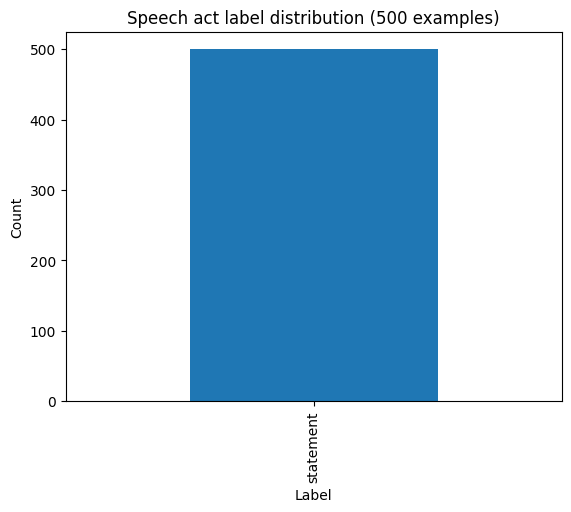

In [20]:
import matplotlib.pyplot as plt

df["label"].value_counts().plot(kind="bar")
plt.title("Speech act label distribution (500 examples)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


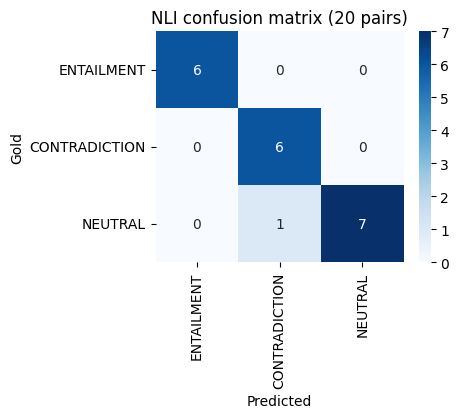

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ["ENTAILMENT", "CONTRADICTION", "NEUTRAL"]
cm = confusion_matrix(gold_labels, pred_labels, labels=labels)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Gold")
plt.title("NLI confusion matrix (20 pairs)")
plt.show()
